# Working with morphologies

In this tutorial, you will learn how to:

- Load morphologies and make them compatible with `Jaxley`  
- Use the visualization features  
- Assemble a small network of morphologically accurate cells.  

Here is a code snippet which you will learn to understand in this tutorial:
```python
import jaxley as jx

cell = jx.read_swc("my_cell.swc", nseg=4, assign_groups=True)
```

To work with more complicated morphologies, `Jaxley` supports importing morphological reconstructions via `.swc` files.
`.swc` is currently the only supported format. Other formats like `.asc` need to be converted to `.swc` first, for example using the BlueBrain's [morph-tool](https://github.com/BlueBrain/morph-tool). For more information on the exact specifications of `.swc` see [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).

In [1]:
import jaxley as jx
from jaxley.synapses import IonotropicSynapse
import matplotlib.pyplot as plt

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader. The reader traces the morphology and identifies all uninterrupted sections. These are then partitioned into branches, each of which will be approximated by a number of equally many compartments that can be simulated fully in parallel.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [2]:
# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = jx.read_swc(fname, nseg=8, max_branch_len=2000.0, assign_groups=True)

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(157, 1256)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,2,2,0,0,0,0
3,3,3,0,0,0,0
4,4,4,0,0,0,0
...,...,...,...,...,...,...
1251,3,1251,156,156,0,0
1252,4,1252,156,156,0,0
1253,5,1253,156,156,0,0
1254,6,1254,156,156,0,0


As we can see, this yields a morphology that is approximated by 1256 compartments. Depending on the amount of detail that you need, you can also change the number of compartments in each branch:

In [3]:
cell = jx.read_swc(fname, nseg=2, max_branch_len=2000.0, assign_groups=True)

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(157, 314)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,0,2,1,1,0,0
3,1,3,1,1,0,0
4,0,4,2,2,0,0
...,...,...,...,...,...,...
309,1,309,154,154,0,0
310,0,310,155,155,0,0
311,1,311,155,155,0,0
312,0,312,156,156,0,0


Once imported the compartmentalized morphology can be viewed using `vis`.  

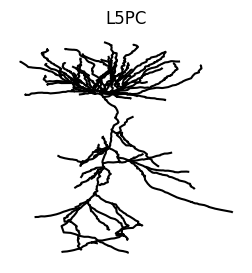

In [4]:
# visualize the cell
cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.show()

`vis` can be called on any `jx.Module` and every `View` of the module. This means we can also for example use `vis` to highlight each branch. This can be done by iterating over each branch index and calling `cell.branch(i).vis()`. Within the loop.

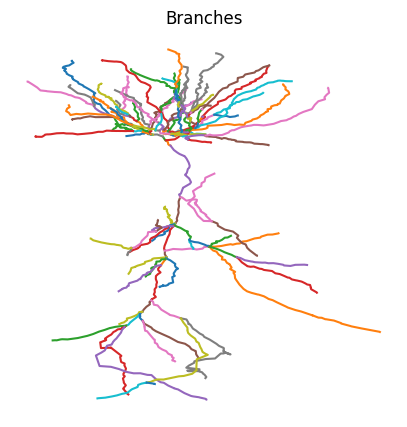

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, col=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. The morphology lives seperately in the `cell.xyzr` attribute in a per branch fashion. 

In addition to plotting the full morphology of the cell using points `vis(type="scatter")` or lines `vis(type="line")`, `Jaxley` also supports plotting a detailed morphological `vis(type="morph")` or approximate compartmental reconstruction `vis(type="comp")` that correctly considers the thickness of the neurite. Note that `"comp"` plots the lengths of each compartment which is equal to the length of the traced neurite. While neurites can be zigzaggy, the compartments that approximate them are straight lines. This can lead to miss-aligment of the compartment ends. For details see the documentation of `vis`. 

The morphologies can either be projected onto 2D or also rendered in 3D. 

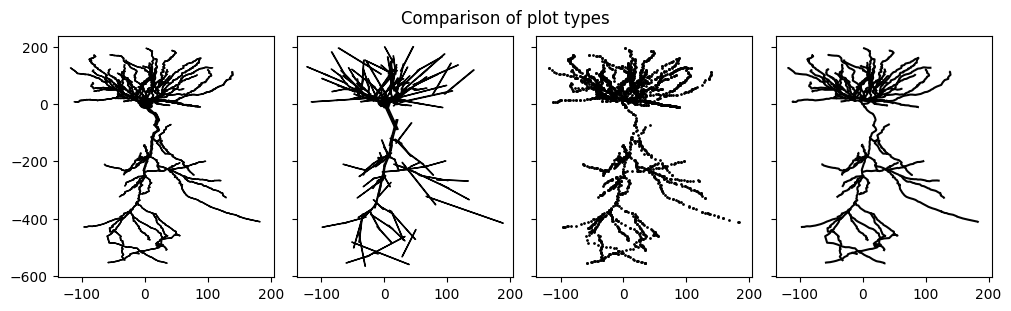

In [6]:
# visualize the cell
fig, ax = plt.subplots(1, 4, figsize=(10, 3), layout="constrained", sharex=True, sharey=True)
cell.vis(ax=ax[0], type="morph", dims=[0,1])
cell.vis(ax=ax[1], type="comp", dims=[0,1])
cell.vis(ax=ax[2], type="scatter", dims=[0,1], morph_plot_kwargs={"s": 1})
cell.vis(ax=ax[3], type="line", dims=[0,1])
fig.suptitle("Comparison of plot types")
plt.show()

In [7]:
# set to interactive mode
# %matplotlib notebook

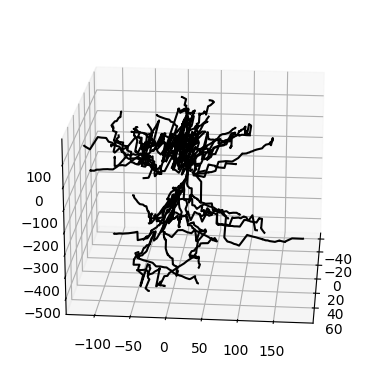

In [8]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cell.vis(ax=ax, type="line", dims=[2,0,1])
ax.view_init(elev=20, azim=5)
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['soma', 'basal', 'apical', 'custom']


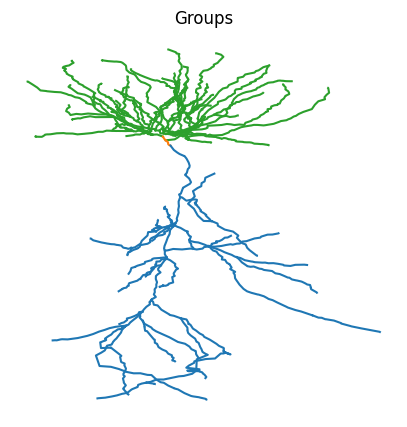

In [9]:
print(list(cell.groups.keys()))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, col=colors[2])
cell.soma.vis(ax=ax, col=colors[1])
cell.apical.vis(ax=ax, col=colors[0])
plt.axis("off")
plt.title("Groups")
plt.show()

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To seperate out the cells, we therefore have to move them to a new location first.

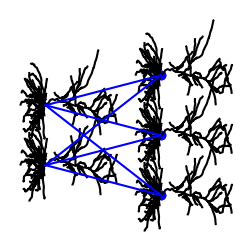

In [10]:
net = jx.Network([cell]*5)
jx.connect(net[0,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[4,0,0], IonotropicSynapse())

jx.connect(net[1,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 300)
net.cell(1).move(0, 500)

net.cell(2).move(900, 200)
net.cell(3).move(900, 400)
net.cell(4).move(900, 600)

net.vis()
plt.axis("off")
plt.show()

Congrats! You have now learned how to vizualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutorial on [how to build a network](https://jaxley.readthedocs.io/en/latest/tutorials/02_small_network.html).